# LSTM Machine Learning Model for SPY ETF Price Prediction

### The following notebook uses a LSTM machine learning model, trained with price data from January 2020 to December 2024 to generate daily predictions for the price of the SPY ETF.

### To generate predictions select Run All from the Run menu.  Scroll to the final cell and input the number of days to predict.

In [5]:
%pip install tensorflow
%pip install pandas
%pip install numpy
%pip install seaborn
%pip install matplotlib



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.rcParams['figure.figsize'] = [12,6]

#Reads input csv to dataframe and converts dates to correct format
data = pd.read_csv('capstone_notebook_data.csv')
data['date'] = pd.to_datetime(data['date'], format='%m/%d/%Y')
data = data[::-1].reset_index(drop=True)

vix_avg = data['VIX close'].mean()

index_2020 = 5074  #Index for first data point in year 2020

#Selects only the data used for model training, values beginning at start of trading in 2020.
data = data.iloc[index_2020:]
data = data.reset_index(drop=True)

data

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


,date,open,high,low,close,volume,VIX close
0,2020-01-02,323.54,324.8900,322.5300,324.87,59037072,12.47
1,2020-01-03,321.16,323.6400,321.1000,322.41,77708081,14.02
2,2020-01-06,320.49,323.7300,320.3600,323.64,55596982,13.85
3,2020-01-07,323.02,323.5400,322.2400,322.73,40461249,13.79
4,2020-01-08,322.94,325.7800,322.6700,324.45,68177241,13.45
...,...,...,...,...,...,...,...
1252,2024-12-23,590.89,595.3000,587.6610,594.69,57635828,16.78
1253,2024-12-24,596.06,601.3400,595.4700,601.30,33160097,14.27
1254,2024-12-26,599.50,602.4800,598.0825,601.34,41338891,14.73
1255,2024-12-27,597.54,597.7761,590.7647,595.01,64969310,15.95


<Axes: >

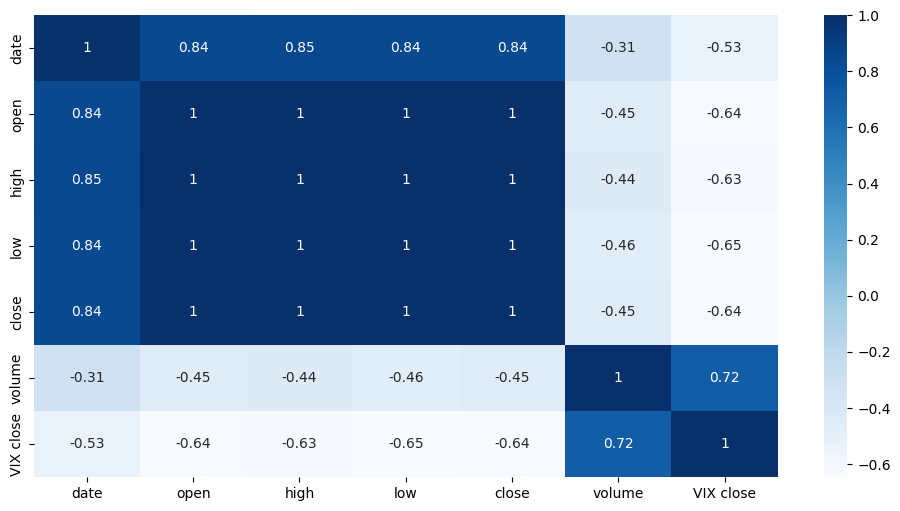

In [6]:
data_ver_matrix = data.corr()
sns.heatmap(data_ver_matrix, cmap="Blues", annot=True)


### The following charts show the daily price trends of the SPY ETF and VIX from 2020 to the present.
### VIX in this model is used as a proxy for investor sentiment as it represents daily market volatility.

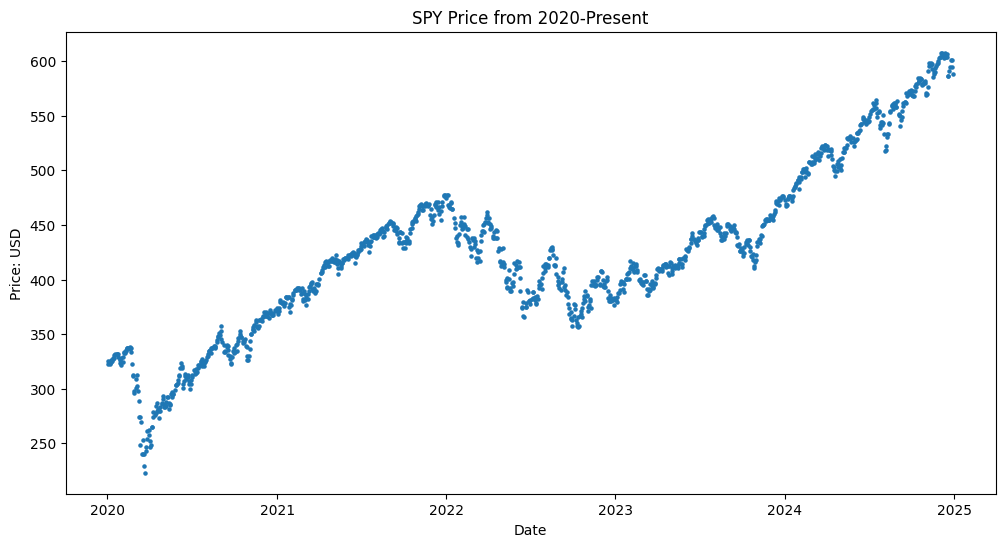

In [7]:
spyplot = plt.scatter(data['date'], data['close'], s = 5)
plt.xlabel('Date')
plt.ylabel('Price: USD')
plt.title('SPY Price from 2020-Present')
plt.show()

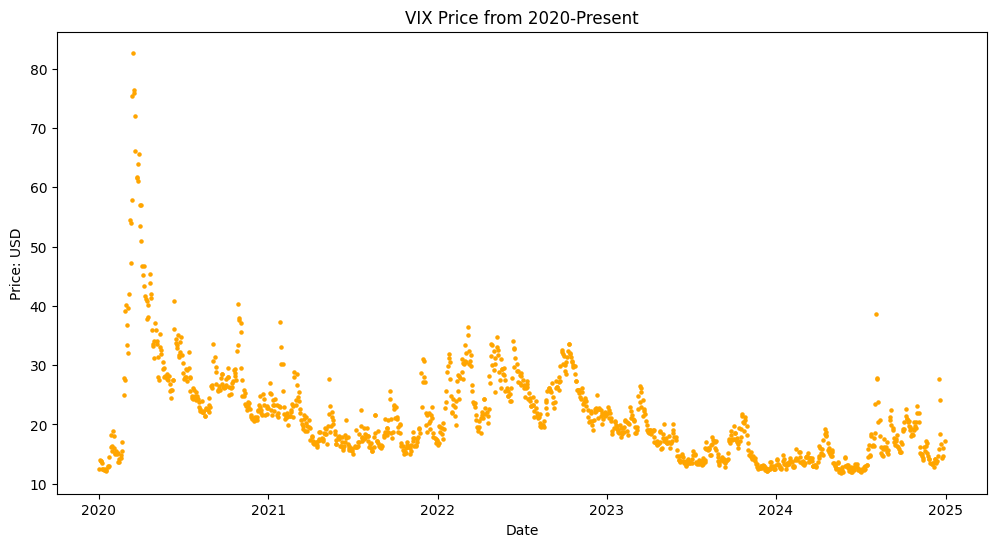

In [8]:
plt.scatter(data['date'], data['VIX close'], s = 5, color = 'orange')
plt.xlabel('Date')
plt.ylabel('Price: USD')
plt.title('VIX Price from 2020-Present')
plt.show()

### As can be observed in these graphs, VIX prices tend to spike during periods of significant market downturn.
### VIX values remain around their average value when the overall market is stable or trending upward.

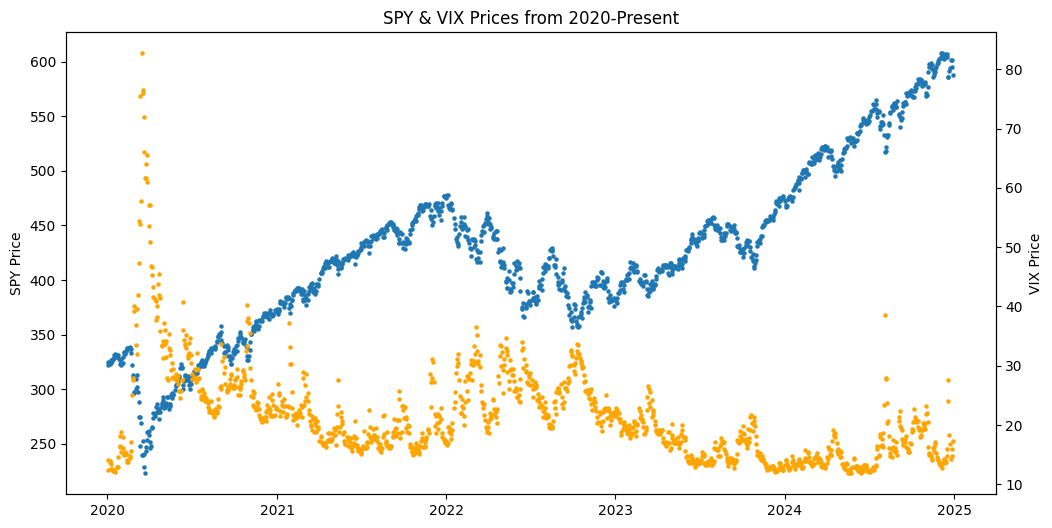

In [9]:
fig, ax1 = plt.subplots()
ax1.scatter(data['date'], data['close'], s = 5)
ax1.set_ylabel('SPY Price')

ax2 = ax1.twinx()
ax2.scatter(data['date'], data['VIX close'], color = 'orange', s = 5)
ax2.set_ylabel('VIX Price')

plt.title('SPY & VIX Prices from 2020-Present')

plt.show()

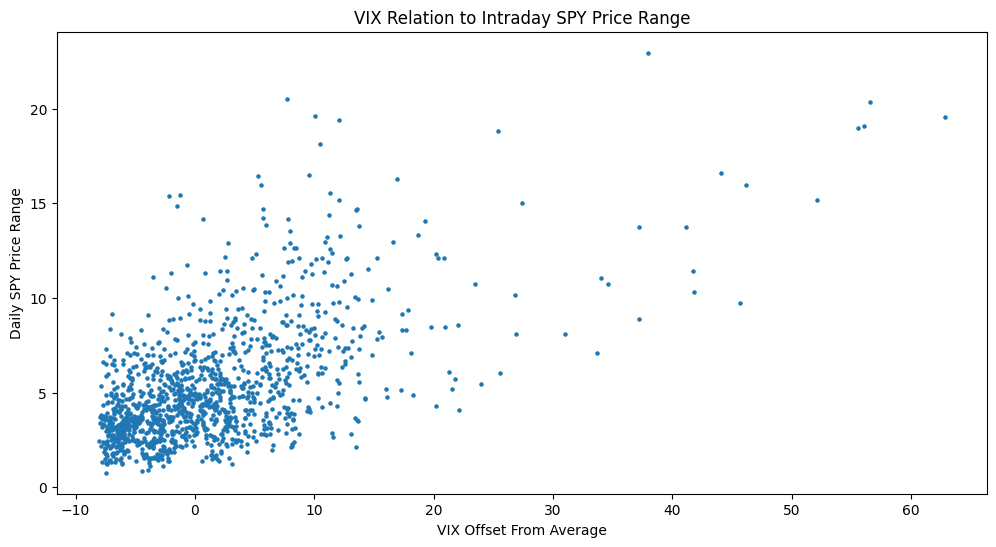

In [10]:
plt.scatter(data['VIX close']-vix_avg, (data['high']-data['low']), s = 5)
plt.xlabel('VIX Offset From Average')
plt.ylabel('Daily SPY Price Range')
plt.title('VIX Relation to Intraday SPY Price Range')
plt.show()

### To prepare data for the model, only the dates, daily SPY closing price and daily VIX closing price are retained.
### A target SPY value for model training is set by shifting the spy values index by -1 and assigning these values
### to a new SPY target column.

In [11]:
data['SPY Target'] = data['close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(drop=True)
data.drop(['open', 'high', 'low', 'volume'], axis=1, inplace=True)
data

,date,close,VIX close,SPY Target
0,2020-01-02,324.87,12.47,322.41
1,2020-01-03,322.41,14.02,323.64
2,2020-01-06,323.64,13.85,322.73
3,2020-01-07,322.73,13.79,324.45
4,2020-01-08,324.45,13.45,326.65
...,...,...,...,...
1251,2024-12-20,591.15,18.36,594.69
1252,2024-12-23,594.69,16.78,601.30
1253,2024-12-24,601.30,14.27,601.34
1254,2024-12-26,601.34,14.73,595.01


### Further data visualizations were produced to examine the relation between the 
### change in the SPY closing prices between days and the VIX closing prices of
### the preceding day.

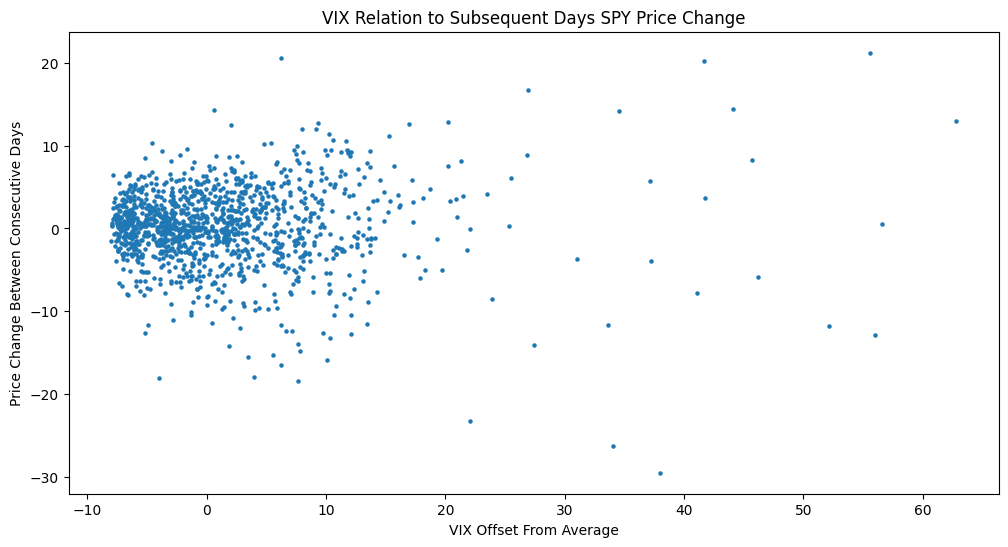

In [12]:
plt.scatter(data['VIX close']-vix_avg, (data['SPY Target']-data['close']), s = 5)
plt.xlabel('VIX Offset From Average')
plt.ylabel('Price Change Between Consecutive Days')
plt.title('VIX Relation to Subsequent Days SPY Price Change')
plt.show()

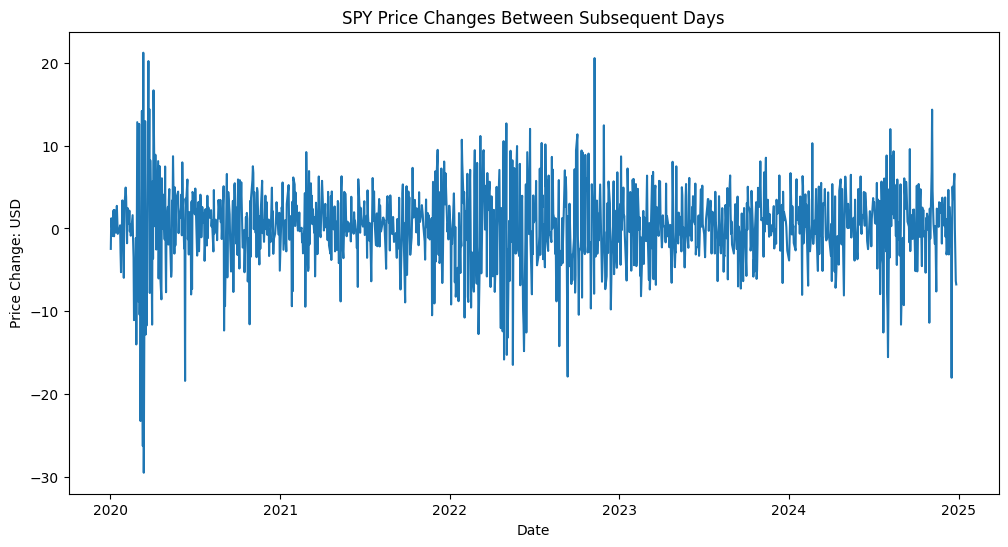

In [13]:
plt.plot(data['date'], data['SPY Target'] - data['close'])
plt.xlabel('Date')
plt.ylabel('Price Change: USD')
plt.title('SPY Price Changes Between Subsequent Days')
plt.show()

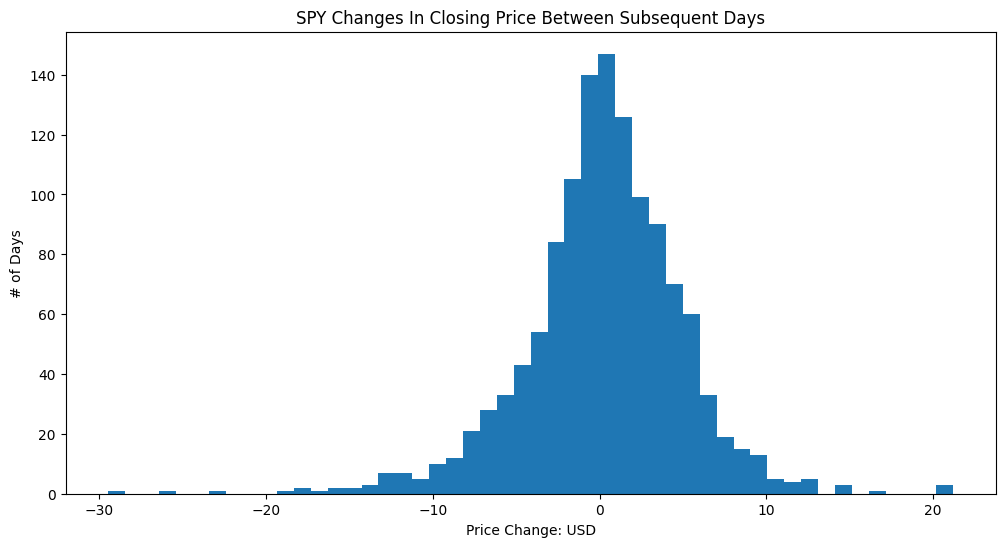

In [14]:
plt.hist(data['SPY Target']- data['close'], bins=50)
plt.title('SPY Changes In Closing Price Between Subsequent Days')
plt.xlabel('Price Change: USD')
plt.ylabel('# of Days')
plt.show()

### A range of training indexes is set to 80% of the total number of samples.

In [15]:
training_index = int(len(data)*0.8)

training_data = data.iloc[:training_index].filter(['date','close', 'VIX close', 'SPY Target']) 

SPY_columns_to_check = ['close']
VIX_columns_to_check = ['VIX close']

#Calculates SPY min & max values used in min-max scaling from the SPY training set domain
SPY_min_value = training_data[SPY_columns_to_check].min().min()
SPY_max_value = training_data[SPY_columns_to_check].max().max()

#Calculates VIX min & max values used in min-max scaling from the VIX training set domain
VIX_min_value = training_data[VIX_columns_to_check].min().min()
VIX_max_value = training_data[VIX_columns_to_check].max().max()


### Values of the SPY price, VIX price and SPY Target price are scaled for use in the model.
### Scaling is done with a min-max scaler calibrated using only the training set to prevent
### data leakage from the testing set to the training set.

In [16]:
#Functions to scale SPY and VIX values used for model training
def SPY_min_max_scaler(df_value):
    return (df_value - SPY_min_value)/(SPY_max_value - SPY_min_value)

def VIX_min_max_scaler(df_value):
    return (df_value - VIX_min_value)/(VIX_max_value - VIX_min_value)

model_data = data.copy()

model_data['close'] = model_data['close'].apply(SPY_min_max_scaler)
model_data['VIX close'] = model_data['VIX close'].apply(VIX_min_max_scaler)
model_data['SPY Target'] = model_data['SPY Target'].apply(SPY_min_max_scaler)

print(model_data)

           date     close  VIX close  SPY Target
0    2020-01-02  0.400063   0.005664    0.390407
1    2020-01-03  0.390407   0.027613    0.395235
2    2020-01-06  0.395235   0.025205    0.391663
3    2020-01-07  0.391663   0.024356    0.398414
4    2020-01-08  0.398414   0.019541    0.407050
...         ...       ...        ...         ...
1251 2024-12-20  1.445282   0.089068    1.459177
1252 2024-12-23  1.459177   0.066695    1.485123
1253 2024-12-24  1.485123   0.031153    1.485280
1254 2024-12-26  1.485280   0.037666    1.460433
1255 2024-12-27  1.460433   0.054942    1.433938

[1256 rows x 4 columns]


### Frames of price data are assembled for use with the LSTM model.  The function creates frames with
### a number of daily closing SPY prices and closing VIX prices determined by the value of time_steps.
### This creates a two feature input for the ml model, composed of the daily closing prices of SPY & VIX.

In [17]:
#Function used to construct input for LSTM model.
#Splits dataframe into date, timestep & features, and target price
#numpy arrays.
def lstm_frame_helper(dataframe, time_steps):
    dates = []
    X = []
    Y = []

    for i in range(time_steps, len(dataframe)):
        dates.append(dataframe.iloc[i-1,0])
        xRow = []
        for j in range(i - time_steps, i):
            xRowElement = []
            xRowElement.append(dataframe.iloc[j, 1])
            xRowElement.append(dataframe.iloc[j, 2])
            xRow.append(xRowElement)
        X.append(xRow)
        Y.append(dataframe.iloc[i-1, 3])
    npDates = np.array(dates)
    npX = np.array(X)
    npX = npX.reshape(len(npX), npX.shape[1], npX.shape[2])
    npY = np.array(Y)

    return npDates, npX, npY

### Dates, SPY price frames and Target SPY price are assigned to different numpy arrays for use with the model.
### The value of time_steps can be altered to feed longer sequences of days into the model.

In [20]:
time_steps = 10
date_array, X_values, Y_values = lstm_frame_helper(model_data, time_steps)

### A training, validation and test split of the data is performed to allocate the first 80% of values to training.
### The subsequent 10% of values are used for validation and the final 10% are used for testing.

In [21]:
training_end = int(len(date_array) * 0.8)
validation_end = int(len(date_array) * 0.9)

train_dates, train_X, train_Y = date_array[:training_end], X_values[:training_end], Y_values[:training_end]
val_dates, val_X, val_Y = date_array[training_end:validation_end], X_values[training_end:validation_end], Y_values[training_end:validation_end]
test_dates, test_X, test_Y = date_array[validation_end:], X_values[validation_end:], Y_values[validation_end:]

### The model uses the tensorflow and keras libraries to construct an LSTM model with one LSTM layer and two dense layers.
### During hyperparameter tuning ten time_steps were found to generate consistently well performing models, while not
### requiring the additional computation required for longer frames.  Tanh activation functions in the dense layers generated
### models that often outperformed other pairings of activation functions in these layers.
### The model will iterate through 300 training epochs or halt training if the model's val_loss does not improve after
### 20 epochs.  The weights of the best model are restored after training is finished.

In [23]:
#Constructs LSTM SPY price model.  Checks if model is saved in inputs before constructing.
#If no model is found an LSTM model is trained and saved in the notebooks output.
#If a model is found the model is loaded and used for subsequent predictions.
'''if not os.path.exists('capstone_model.keras'):

    from tensorflow.keras.models import Sequential
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras import layers
    from tensorflow.keras import callbacks
    
    callback = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    model = Sequential([layers.Input((time_steps,2)), layers.LSTM(64), layers.Dense(64, activation='tanh'), layers.Dense(64, activation='tanh'), layers.Dense(1)])
    
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001),metrics=['mean_absolute_error', 'mse'])
    
    model.fit(train_X, train_Y, validation_data=(val_X, val_Y), epochs=300, callbacks=[callback])
    
    model.save('price_model.keras')

else:
'''
from tensorflow.keras.models import load_model
model = load_model('capstone_model.keras')

Epoch 1/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.1464 - mean_absolute_error: 0.2923 - mse: 0.1464 - val_loss: 6.2522e-04 - val_mean_absolute_error: 0.0200 - val_mse: 6.2522e-04
Epoch 2/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0042 - mean_absolute_error: 0.0537 - mse: 0.0042 - val_loss: 0.0041 - val_mean_absolute_error: 0.0593 - val_mse: 0.0041
Epoch 3/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0014 - mean_absolute_error: 0.0278 - mse: 0.0014 - val_loss: 0.0023 - val_mean_absolute_error: 0.0434 - val_mse: 0.0023
Epoch 4/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0011 - mean_absolute_error: 0.0250 - mse: 0.0011 - val_loss: 0.0024 - val_mean_absolute_error: 0.0443 - val_mse: 0.0024
Epoch 5/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0011 - mean_absolute_error: 0.0239 - mse: 0.0011 - val_loss: 0.0016 - val_mean_absolute_error: 0.0354 - val_mse: 0.0016
Epoch 6/300
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 9.0382e-04 - mean_abso

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


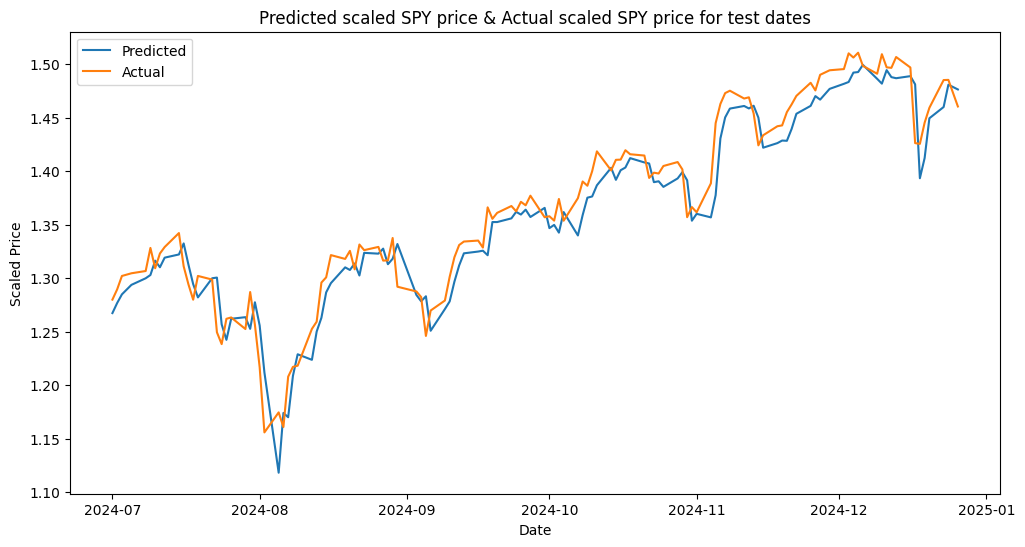

In [39]:
test_pred =model.predict(test_X) #Generates model predictions from testing set input values
plt.plot(test_dates, test_pred)
plt.plot(test_dates, test_Y)
plt.legend(['Predicted', 'Actual'])
plt.ylabel('Scaled Price')
plt.xlabel('Date')
plt.title('Predicted scaled SPY price & Actual scaled SPY price for test dates')
plt.show()


In [40]:
#Reverses scaling of values that were previously scaled for model input.
#Uses the min and max values of the training data set to unscale predictions.
def SPY_inverse_scaling(value):
    return value * (SPY_max_value - SPY_min_value) + SPY_min_value
def SPY_inverse_scaler(values):
    for i in range(0, len(values)):
        values[i] = SPY_inverse_scaling(values[i])

train_pred = model.predict(train_X)
test_pred =model.predict(test_X)
val_pred = model.predict(val_X)

SPY_inverse_scaler(train_pred)
SPY_inverse_scaler(val_pred)
SPY_inverse_scaler(test_pred)
SPY_inverse_scaler(test_Y)
SPY_inverse_scaler(train_Y)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


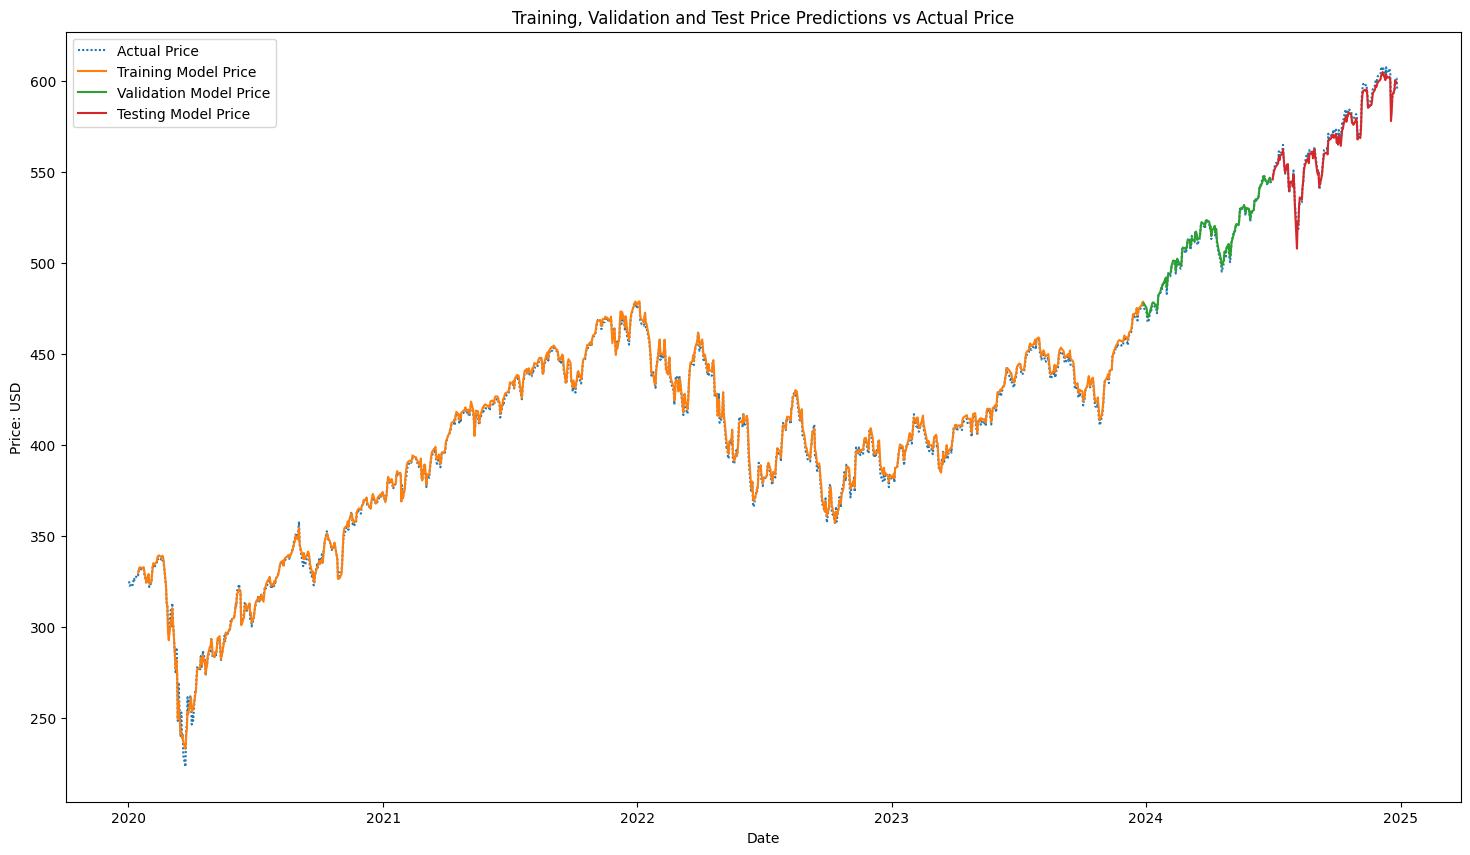

In [41]:
plt.figure(figsize=(18,10))
plt.plot(data['date'], data['close'], linestyle=(0,(1,1)))
plt.plot(train_dates, train_pred)
plt.plot(val_dates, val_pred)
plt.plot(test_dates, test_pred)
plt.legend(['Actual Price', 'Training Model Price', 'Validation Model Price', 'Testing Model Price'])
plt.xlabel('Date')
plt.ylabel('Price: USD')
plt.title('Training, Validation and Test Price Predictions vs Actual Price')
plt.show()

In [42]:
from tensorflow.keras import losses
from tensorflow.keras import backend as K

test_pred = test_pred.flatten()
test_MAPE = losses.MAPE(test_Y, test_pred)
test_MAE = losses.MAE(test_Y, test_pred)

train_pred = train_pred.flatten()
train_MAPE = losses.MAPE(train_Y, train_pred)
train_MAE = losses.MAE(train_Y, train_pred)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

rmse_test = root_mean_squared_error(test_Y, test_pred)
rmse_train = root_mean_squared_error(train_Y, train_pred)


print("Test MAPE Value: ", test_MAPE)
print('Test MAE Value: ', test_MAE)
print("Test RMSE Value: ", rmse_test, '\n')

print("Train MAPE Value: ", train_MAPE)
print('Train MAE Value: ', train_MAE)
print("Train RMSE Value: ", rmse_train)

Test MAPE Value:  tf.Tensor(0.7880461, shape=(), dtype=float32)
Test MAE Value:  tf.Tensor(4.4743643, shape=(), dtype=float32)
Test RMSE Value:  tf.Tensor(5.565396560321549, shape=(), dtype=float64) 

Train MAPE Value:  tf.Tensor(0.9964979, shape=(), dtype=float32)
Train MAE Value:  tf.Tensor(3.7696908, shape=(), dtype=float32)
Train RMSE Value:  tf.Tensor(5.11117417507273, shape=(), dtype=float64)


# Enter number of desired days to predict price as the assignment for days_predicted variable in the cell below and run both of the final cells.
### Cells can be run repeatedly, in order, with new values for days_to_predict to generate different time frames of predicted prices.

In [43]:
days_to_predict = 4      #******Enter the integer number of advance trading days to predict.  Values beyond 5 are discouraged as the models accuracy worsens for longer series of recursive predictions.******

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
SPY Price For Trading Days Beyond Current Trading Day:
Day 1 - $593.52
Day 2 - $587.74
Day 3 - $585.35
Day 4 - $583.74


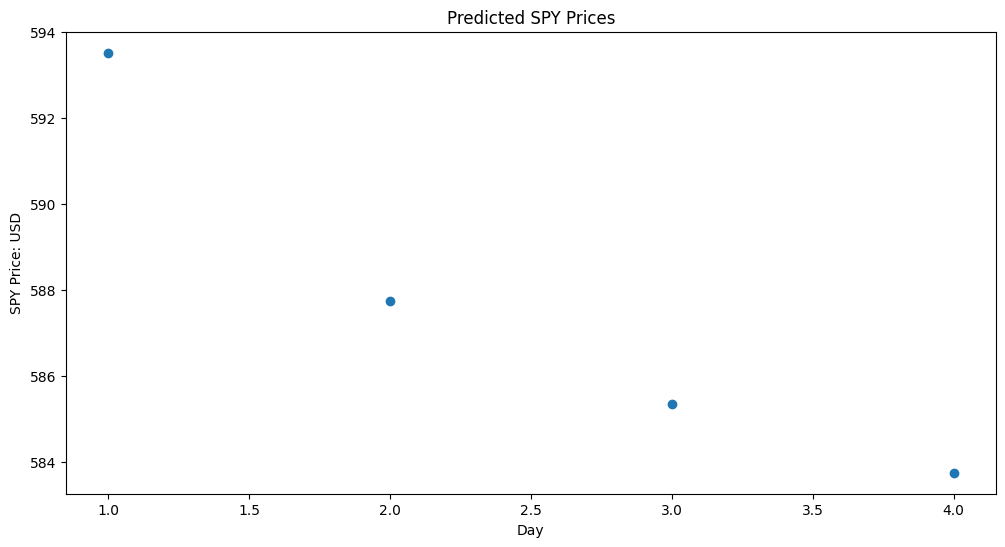

In [44]:
import copy

end_value_data = copy.deepcopy(model_data[-10:])

last_frame = []


# Constructs input for model prediction with last 10 timestep window from current data set.
for i in range(time_steps):
    append_vals = []
    append_vals.append(end_value_data.iloc[i, 1])
    append_vals.append(end_value_data.iloc[i,2])
    last_frame.append(append_vals)
last_frame = np.array(last_frame)
last_frame = last_frame.reshape(1, last_frame.shape[0], last_frame.shape[1])

predicted_prices = []  #Stores list of predicted prices.

scaled_VIX_avg = VIX_min_max_scaler(vix_avg) #Scales average VIX value for use as VIX value in predicted timesteps

days_predicted = int(days_to_predict) # Input correction for number of days to predict


#Constructs new frame to append to the sequence of frames used for predictions.
#Generates a prediction, then uses the prediction and the average vix value
#to create the latest timestep in a new frame.  The frame is appended to the
#array of frames used for predictions. This process repeats to generate daily
#predictions for days_predicted number of days and adds the predictions to
#the list predicted_prices used for outputing predictions.
for i in range(0, days_predicted):
    values_predicted = model.predict(last_frame)
    predicted_prices.append(values_predicted[-1][0])
    value_frame_to_add = copy.deepcopy(last_frame[-1])
    
    for j in range(0,time_steps-1):
        value_frame_to_add[j][0] = last_frame[-1][j+1][0]
        value_frame_to_add[j][1] = last_frame[-1][j+1][1]

    value_frame_to_add[time_steps-1][0] = predicted_prices[-1]
    value_frame_to_add[time_steps-1][1] = scaled_VIX_avg
    value_frame_to_add = value_frame_to_add.reshape(1,time_steps,2)
    last_frame = np.append(last_frame, value_frame_to_add, axis=0)

    
SPY_inverse_scaler(predicted_prices)  # Unscales predicted prices.
days = [i+1 for i in range(days_predicted)]   # Constructs list of days for plotting prices.


print('SPY Price For Trading Days Beyond Current Trading Day:')
for i in range(0, days_predicted):
    print(f"Day {i+1} - ${predicted_prices[i]:.2f}")


plt.scatter(days, predicted_prices)
plt.xlabel('Day')
plt.ylabel('SPY Price: USD')
plt.title('Predicted SPY Prices')
plt.show()